<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/Machine_Learning_Multi_output_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#package installation

#installing skicit learn (not needed)
!pip install scikit-learn

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#trying the hypercube some other way
!pip install stats_arrays

#using mcerp package
!pip install mcerp

#Installing PROSAIL
!pip install prosail

In [0]:
#importing packages

#regular packages for python
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

#latin hypercube stuff
import lhsmdu

#rtm model
import prosail

#importing pandas
import pandas as pd

#machine learning tuff
from sklearn.neural_network import MLPRegressor


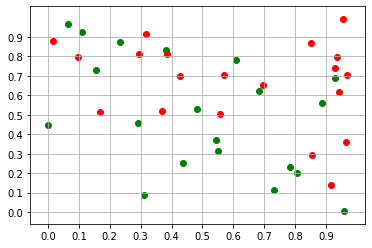

In [0]:


#Generating a latin hypercube sample structure 

#Logic: 1. generate a LHS sample in n dimensions from 0 to 1 in each. 2. Multiply this n dimensions by the maximum value of the trait 

#example taken from here https://github.com/sahilm89/lhsmdu
k = lhsmdu.sample(2, 20) # Latin Hypercube Sampling with multi-dimensional uniformity
l = lhsmdu.createRandomStandardUniformMatrix(2, 20) # Monte Carlo sampling

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(numpy.arange(0,1,0.1))
ax.set_yticks(numpy.arange(0,1,0.1))
plt.scatter([k[0]], [k[1]],c="g", label="LHS-MDU")
plt.scatter([l[0]], [l[1]],c="r", label="MC")
plt.grid()
plt.show()

#the uniform approach seems better but also seems that its a lot slower

In [0]:
#using the previous approach to generate a big sample of traits

samples_n = 500

trait_3d_lhs = lhsmdu.createRandomStandardUniformMatrix(3,samples_n) #perhaps this one is not as good but its definitly faster


In [0]:
#setting up default values for PROSAIL:

#https://github.com/jgomezdans/prosail
#lets make a stupid list of defaults
n=1.5
cab=80.
car=8.
cw=0.0
cbrown=0.01
cm=0.009
lai =3.


#leaf angles are bit messier - before choosing lidfa we must check how ti relates with typelidf
#typelidf = 1 #implies that we should give it 2 paramaters 
#typelidf = 2 #implies elipsoidal distributions with only lidfa being given: etc etc
#default is 2, we keep it as such because this is just a playaround

lidfa = -0.35 #
lidfb=-0.15

#lidfa = 0.0 #default value

#hotspot is a kind of weird concept 
hspot=0.01

#observer position
tts=30.
tto=10. 
psi=0.


In [0]:

#now it is easy to plot or access each trait 

LAI_max = 10.
Chl_max = 90.
CmL_max = 0.008

#this weird code makes a dataframe like i prefer
pd_trait3d = pd.DataFrame.transpose(pd.DataFrame(trait_3d_lhs))
pd_trait3d.columns = ["LAI","Cab","Cm"]

#this is better than using a stupid loop...
pd_trait3d["LAI"]=pd_trait3d["LAI"]*LAI_max
pd_trait3d["Cab"]=pd_trait3d["Cab"]*Chl_max
pd_trait3d["Cm"]=pd_trait3d["Cm"]*CmL_max

#looks good
print(pd_trait3d)



          LAI        Cab        Cm
0    8.900053  62.455360  0.004945
1    3.379952  48.845200  0.005620
2    3.755830  22.661915  0.004477
3    0.939819  31.112639  0.000078
4    5.782801  16.343795  0.002612
..        ...        ...       ...
495  1.499174   9.443716  0.002523
496  2.292514  21.784051  0.005505
497  7.222526  88.799633  0.003501
498  7.200365  12.824599  0.002037
499  6.411476  44.899934  0.006727

[500 rows x 3 columns]


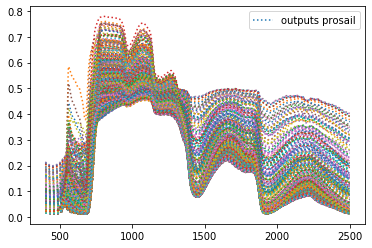

In [0]:

#aux for x axis
x = np.arange(400,2501)
x[-1]




k = 1
#for i in range(10):
for i in range(len(pd_trait3d)):
    #print(i)

    lai_t = pd_trait3d["LAI"][i]
    cab_t = pd_trait3d["Cab"][i]
    cm_t = pd_trait3d["Cm"][i]


    if k == 1:
      rho_s = prosail.run_prosail(n, cab_t, car, cw, cbrown, cm_t, lai_t, lidfa, hspot, 
                                 tts, tto, psi,
                                 prospect_version='D', typelidf=1, lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
      plt.plot ( x, rho_s, ':', label="outputs prosail")
      plt.legend(loc='best')
      
    if k > 1:
      rho_t = prosail.run_prosail(n, cab_t, car, cw, cbrown, cm_t, lai_t, lidfa, hspot, 
                                tts, tto, psi,
                                prospect_version='D', typelidf=1, lidfb=-0.15,
                                factor='SDR', rsoil=1., psoil=1.)  
      rho_s = numpy.vstack((rho_s,rho_t))
      plt.plot ( x, rho_t, ':')

    
    k = k+1

plt.show()



In [0]:
#ITS ALIVE!! (not sure what is though lol )
clf = MLPRegressor(solver='adam', alpha=1e-5,
                   hidden_layer_sizes=(30, 20,10,3),
                   #activation="tanh",
                   max_iter=1000,
                   random_state=1)

clf.fit(rho_s,pd_trait3d)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(30, 20, 10, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=1000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
#using a gaussian processe regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
noise = 0.2
gpr = GaussianProcessRegressor()

gpr.fit(rho_s, pd_trait3d)



NameError: ignored

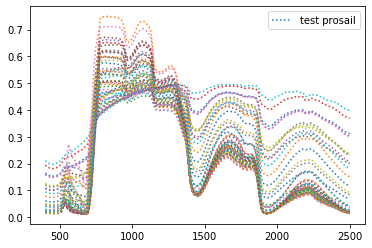

In [0]:
#now lets try it on new data, just 50 points

test_trait_3d_lhs = lhsmdu.createRandomStandardUniformMatrix(3,50) #perhaps this one is not as good but its definitly faster

#this weird code makes a dataframe like i prefer
pd_test_trait3d = pd.DataFrame.transpose(pd.DataFrame(test_trait_3d_lhs))
pd_test_trait3d.columns = ["LAI","Cab","Cm"]

pd_test_trait3d["LAI"]=pd_test_trait3d["LAI"]*LAI_max
pd_test_trait3d["Cab"]=pd_test_trait3d["Cab"]*Chl_max
pd_test_trait3d["Cm"]=pd_test_trait3d["Cm"]*CmL_max

#now we generate the test dataset following the same loop as before - probably its better to one day create a function for that.. otherwise i just have to keep repeating that stupid loop. 

k = 1
#for i in range(10):
for i in range(len(pd_test_trait3d)):
    #print(i)

    lai_t = pd_test_trait3d["LAI"][i]
    cab_t = pd_test_trait3d["Cab"][i]
    cm_t = pd_test_trait3d["Cm"][i]


    if k == 1:
      test_rho_s = prosail.run_prosail(n, cab_t, car, cw, cbrown, cm_t, lai_t, lidfa, hspot, 
                                 tts, tto, psi,
                                 prospect_version='D', typelidf=1, lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
      plt.plot ( x, test_rho_s, ':', label="test prosail")
      plt.legend(loc='best')
      
    if k > 1:
      test_rho_t = prosail.run_prosail(n, cab_t, car, cw, cbrown, cm_t, lai_t, lidfa, hspot, 
                                tts, tto, psi,
                                prospect_version='D', typelidf=1, lidfb=-0.15,
                                factor='SDR', rsoil=1., psoil=1.)  
      test_rho_s = numpy.vstack((test_rho_s,test_rho_t))
      plt.plot ( x, test_rho_t, ':')

    
    k = k+1

plt.show()




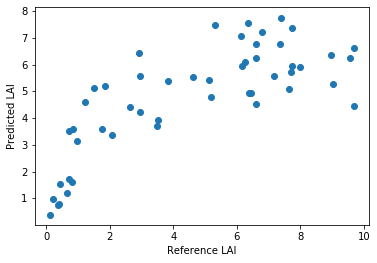

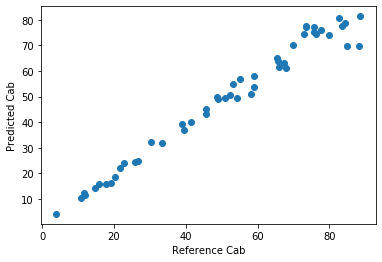

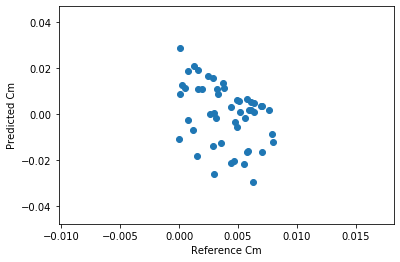

In [0]:

#now we should everything for a prediction

arr_pred = clf.predict(test_rho_s)

pd_pred = pd.DataFrame(arr_pred)
pd_pred.columns = ["LAI","Cab","Cm"]

plt.scatter(pd_test_trait3d["LAI"],pd_pred["LAI"])
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.show()

plt.scatter(pd_test_trait3d["Cab"],pd_pred["Cab"])
plt.xlabel("Reference Cab")
plt.ylabel("Predicted Cab")
plt.show()


plt.scatter(pd_test_trait3d["Cm"],pd_pred["Cm"])
plt.xlabel("Reference Cm")
plt.ylabel("Predicted Cm")
plt.show()

In [0]:
arr_pred_gp = gpr.predict(test_rho_s)


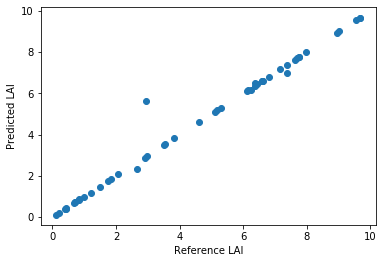

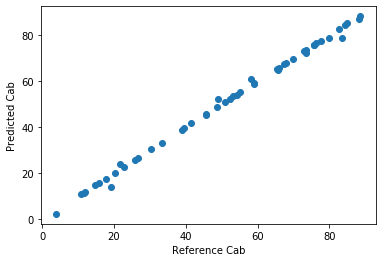

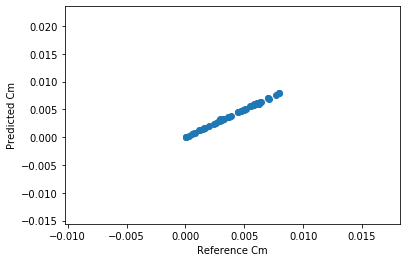

In [0]:
pd_pred = pd.DataFrame(arr_pred_gp)
pd_pred.columns = ["LAI","Cab","Cm"]

plt.scatter(pd_test_trait3d["LAI"],pd_pred["LAI"])
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.show()

plt.scatter(pd_test_trait3d["Cab"],pd_pred["Cab"])
plt.xlabel("Reference Cab")
plt.ylabel("Predicted Cab")
plt.show()


plt.scatter(pd_test_trait3d["Cm"],pd_pred["Cm"])
plt.xlabel("Reference Cm")
plt.ylabel("Predicted Cm")
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(pd_test_trait3d["LAI"],pd_pred["LAI"]))
print(rms)

NameError: ignored

In [0]:
#testing prospect

#x           = n,cab,car,cbrown,cw,cm
#bdns        = ((1,4),(0,80),(0,20),(0,1),(0,0.025),(0,0.015))

n=1 #the max n value must be 2, and the minimum 1 - leafs with n structure lower than 1
cab=50.
car=18.
cbrown=.8
cw=.001
cm=.001

samples_n = 5000

trait_6d_lhs = lhsmdu.createRandomStandardUniformMatrix(6,samples_n) #perhaps this one is not as good but its definitly faster

#this weird code makes a dataframe like i prefer
pd_trait6d = pd.DataFrame.transpose(pd.DataFrame(trait_6d_lhs))
pd_trait6d.columns = ["n","cab","car","cbrown","cw","cm"]

#this is better than using a stupid loop...
pd_trait6d["n"]=pd_trait6d["n"]*n+1
pd_trait6d["cab"]=pd_trait6d["cab"]*cab
pd_trait6d["car"]=pd_trait6d["car"]*car
pd_trait6d["cbrown"]=pd_trait6d["cbrown"]*cbrown
pd_trait6d["cw"]=pd_trait6d["cw"]*cw
pd_trait6d["cm"]=pd_trait6d["cm"]*cm

#looks good
print(pd_trait6d)

#check for negatives 

             n        cab        car    cbrown        cw        cm
0     1.485640  31.920452  17.510228  0.001926  0.000951  0.000640
1     1.845662  49.898964   5.268863  0.443486  0.000889  0.000733
2     1.590956  48.220695   1.014576  0.283313  0.000377  0.000125
3     1.521849  14.852950  16.740099  0.161641  0.000849  0.000292
4     1.053926  46.808382  11.578255  0.587290  0.000222  0.000327
...        ...        ...        ...       ...       ...       ...
4995  1.607802   4.601629  12.246747  0.386560  0.000310  0.000185
4996  1.587943  35.259166  14.713545  0.383175  0.000808  0.000959
4997  1.059179  40.573189  12.079514  0.414073  0.000060  0.000801
4998  1.277982  31.581615  13.938884  0.139171  0.000312  0.000134
4999  1.187899  15.818792  17.805191  0.641592  0.000734  0.000046

[5000 rows x 6 columns]


In [0]:
prosail.run_prospect?

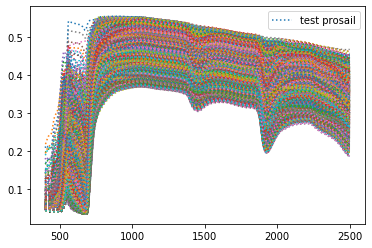

In [0]:
#aux for x axis
x = np.arange(400,2501)
x[-1]


k = 1
#for i in range(10):
for i in range(len(pd_trait6d)):
    #print(i)

    n_t = pd_trait6d["n"][i]
    cab_t = pd_trait6d["cab"][i]
    car_t = pd_trait6d["car"][i]
    cbrown_t = pd_trait6d["cbrown"][i]
    cw_t = pd_trait6d["cw"][i]
    cm_t = pd_trait6d["cm"][i]

    if k == 1:
      pros_rho_s = prosail.run_prospect(n_t,cab_t,car_t,cbrown_t,cw_t,cm_t)[1]
      plt.plot ( x, pros_rho_s, ':', label="test prosail")
      plt.legend(loc='best')
      
    if k > 1:
      pros_rho_t = prosail.run_prospect(n_t,cab_t,car_t,cbrown_t,cw_t,cm_t)[1]
      pros_rho_s = numpy.vstack((pros_rho_s,pros_rho_t))
      plt.plot ( x, pros_rho_t, ':')

    
    k = k+1

plt.show()


In [0]:
i =32
print(pd_trait6d["n"][i])
print(pd_trait6d["cab"][i])
print(pd_trait6d["car"][i])
print(pd_trait6d["cbrown"][i])
print(pd_trait6d["cw"][i])
print(pd_trait6d["cm"][i])

1.780151139201042
7.268052127805824
10.01787682902533
0.05150217533624604
0.000767423870390922
0.0007728218190288746


In [0]:
i =33
print(pd_trait6d["n"][i])
print(pd_trait6d["cab"][i])
print(pd_trait6d["car"][i])
print(pd_trait6d["cbrown"][i])
print(pd_trait6d["cw"][i])
print(pd_trait6d["cm"][i])


prosail.run_prospect(pd_trait6d["n"][i],
                     pd_trait6d["cab"][i],
                     pd_trait6d["car"][i],
                     pd_trait6d["cbrown"][i],
                     pd_trait6d["cw"][i],
                     pd_trait6d["cm"][i])

0.002628778138067167
38.62140427048066
12.92127189059563
0.4694138945462708
8.544795860864118e-05
0.0007447655848927823


/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:150: RuntimeWarning: divide by zero encountered in true_divide
  b       = (1-rq+tq+D)/(2*t)
/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:150: RuntimeWarning: overflow encountered in true_divide
  b       = (1-rq+tq+D)/(2*t)
/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:166: RuntimeWarning: divide by zero encountered in true_divide
  tran    = Ta*Tsub/denom
/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:166: RuntimeWarning: invalid value encountered in true_divide
  tran    = Ta*Tsub/denom
/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:167: RuntimeWarning: divide by zero encountered in true_divide
  refl    = Ra+Ta*Rsub*t/denom
/usr/local/lib/python3.6/dist-packages/prosail/prospect_d.py:167: RuntimeWarning: invalid value encountered in true_divide
  refl    = Ra+Ta*Rsub*t/denom


(array([ 400,  401,  402, ..., 2498, 2499, 2500]),
 array([        nan,         nan,         nan, ..., -0.0388822 ,
        -0.03884309, -0.03892001]),
 array([       nan,        nan,        nan, ..., 0.99856453, 0.99788926,
        0.99871727]))

In [0]:
pros_rho_s.shape

(5000, 2101)

In [0]:
GaussianProcessRegressor?

In [0]:
#lets get some ML running on this crap

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern




prospect_grp = GaussianProcessRegressor(n_restarts_optimizer=20,
                                        #normalize_y=True,
                                        random_state=1)

prospect_grp.fit(pros_rho_s, pd_trait6d)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=20, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=1)

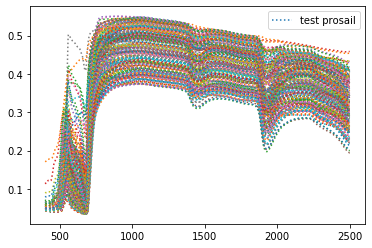

249


In [0]:
#creating a test dataset

n=1. #same rule as before
cab=50.
car=18.
cbrown=.8
cw=.001
cm=.001

samples_n = 250

test_trait_6d_lhs = lhsmdu.createRandomStandardUniformMatrix(6,samples_n) #perhaps this one is not as good but its definitly faster

#this weird code makes a dataframe like i prefer
test_pd_trait6d = pd.DataFrame.transpose(pd.DataFrame(test_trait_6d_lhs))
test_pd_trait6d.columns = ["n","cab","car","cbrown","cw","cm"]

#this is better than using a stupid loop...
test_pd_trait6d["n"]=test_pd_trait6d["n"]*n+1
test_pd_trait6d["cab"]=test_pd_trait6d["cab"]*cab
test_pd_trait6d["car"]=test_pd_trait6d["car"]*car
test_pd_trait6d["cbrown"]=test_pd_trait6d["cbrown"]*cbrown
test_pd_trait6d["cw"]=test_pd_trait6d["cw"]*cw
test_pd_trait6d["cm"]=test_pd_trait6d["cm"]*cm


k = 1
#for i in range(10):
for i in range(len(test_pd_trait6d)):
    #print(i)

    n_t = test_pd_trait6d["n"][i]
    cab_t = test_pd_trait6d["cab"][i]
    car_t = test_pd_trait6d["car"][i]
    cbrown_t = test_pd_trait6d["cbrown"][i]
    cw_t = test_pd_trait6d["cw"][i]
    cm_t = test_pd_trait6d["cm"][i]

    if k == 1:
      t_pros_rho_s = prosail.run_prospect(n_t,cab_t,car_t,cbrown_t,cw_t,cm_t)[1]
      plt.plot ( x, t_pros_rho_s, ':', label="test prosail")
      plt.legend(loc='best')
      
    if k > 1:
      t_pros_rho_t = prosail.run_prospect(n_t,cab_t,car_t,cbrown_t,cw_t,cm_t)[1]
      t_pros_rho_s = numpy.vstack((t_pros_rho_s,pros_rho_t))
      plt.plot ( x, t_pros_rho_t, ':')

    
    k = k+1

plt.show()
print(i)

In [0]:
prospect_pred_gp = prospect_grp.predict(t_pros_rho_s)

prospect_pd_pred = pd.DataFrame(prospect_pred_gp)
prospect_pd_pred

,0,1,2,3,4,5
0,1.314005,13.224570,5.780617,0.694802,0.000182,0.000451
1,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
2,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
3,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
4,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
...,...,...,...,...,...,...
245,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
246,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
247,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046
248,1.187899,15.818794,17.805193,0.641592,0.000734,0.000046


In [0]:
#run this one for neural network on prospect data
prospect_clf = MLPRegressor(solver='adam', alpha=1e-5,
                   hidden_layer_sizes=(30, 20,10,6),
                   #activation="tanh",
                   max_iter=1000,
                   random_state=1)

prospect_clf.fit(pros_rho_s,pd_trait6d)

prospect_pred_clf = prospect_clf.predict(t_pros_rho_s)

prospect_pd_pred = pd.DataFrame(prospect_pred_clf)
prospect_pd_pred



,0,1,2,3,4,5
0,1.424395,13.233717,5.524467,0.428638,0.013253,-0.006093
1,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
2,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
3,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
4,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
...,...,...,...,...,...,...
245,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
246,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
247,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709
248,1.201133,15.574302,15.384879,0.418730,0.015424,-0.060709


In [0]:
#prospect_pd_pred = pd.DataFrame(prospect_pred_gp)
#check on the previous set if you are running neural network or gaussian processes
prospect_pd_pred.columns = ["n","cab","car","cbrown","cw","cm"]

plt.scatter(test_pd_trait6d["n"],prospect_pd_pred["n"])
plt.xlabel("Reference n")
plt.ylabel("Predicted n")
plt.show()

plt.scatter(test_pd_trait6d["cab"],prospect_pd_pred["cab"])
plt.xlabel("Reference Cab")
plt.ylabel("Predicted Cab")
plt.show()

plt.scatter(test_pd_trait6d["car"],prospect_pd_pred["car"])
plt.xlabel("Reference Car")
plt.ylabel("Predicted Car")
plt.show()

plt.scatter(test_pd_trait6d["cbrown"],prospect_pd_pred["cbrown"])
plt.xlabel("Reference cbrown")
plt.ylabel("Predicted Cbrown")
plt.show()

plt.scatter(test_pd_trait6d["cw"],prospect_pd_pred["cw"])
plt.xlabel("Reference cw")
plt.ylabel("Predicted cw")
plt.show()

plt.scatter(test_pd_trait6d["cm"],prospect_pd_pred["cm"])
plt.xlabel("Reference Cm")
plt.ylabel("Predicted Cm")
plt.show()

NameError: ignored